<a href="https://colab.research.google.com/github/blueeagle100/3d_bounding_boxes/blob/main/3d_box_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Bounding Boxes from Stereo Images**

In this tutorial we will learn how to draw 3D bounding boxes on detected objects. The high level pipeline will be:
- In the camera images, detect objects in 2D 
- Project Stereo Depth information into 3D space
- Get 3D location of object in image/camera space
- Draw 3D bounding box


We will use the KITTI dataset which can be accessed [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-09-05 14:23:54--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.243
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  32.4MB/s    in 29s     

2022-09-05 14:24:23 (31.1 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-09-05 14:24:23--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.123
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-09-05 14:24:24 (41.3 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [218]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [219]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [1]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [2]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")

Number of left images: 227
Number of right images: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [3]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get distortion coefficients
d_left = [float(x) for x in calib[20].strip().split(' ')[1:]]
d_right = [float(x) for x in calib[28].strip().split(' ')[1:]]

# get unrectified intrinic matrices?
K_left_unrect = np.array([float(x) for x in calib[19].strip().split(' ')[1:]]).reshape((3, 3,))
K_right_unrect = np.array([float(x) for x in calib[27].strip().split(' ')[1:]]).reshape((3, 3,))

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [4]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [5]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

## **Create Stereo Depth Pipeline**

In [6]:
# set number of disparities
NUM_DISPARITIES = 96

In [7]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

In [8]:
def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

## **Get Object Detection Pipeline**

Any object detector should work, but we will use yolov5 to get the job done.

In [9]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [10]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [11]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-9-5 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [12]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [13]:
def get_distances(image, depth_map, bboxes, method='median', draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
          bboxes_out - updated bboxes to inluve (u,v,z) object center locations
        '''

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
        
        # get center location on image
        x_center = np.round((pt1[1] + pt2[1]) / 2).astype(int)
        y_center = np.round((pt1[0] + pt2[0]) / 2).astype(int)

        # get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

        # compute median depth to get the distance
        if method == 'center':
            x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
            y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
            stereo_depth = depth_slice[x_c, y_c]
        else:
            stereo_depth = np.median(depth_slice)

        # draw depth on image at center of each bounding box
        if draw:
            cv2.putText(image, 
                        '{0:.2f} m'.format(stereo_depth), 
                        (y_center, x_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    

        # add object_center (u, v, z) to bboxes
        bboxes_out[i, -3:] = np.array([x_center, y_center, stereo_depth])
        
    return image, bboxes_out

In [14]:
def get_depth_detections(left_image, right_image, method='median', 
                         draw_boxes=True, draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    # convert to grayscale
    left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
    right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

    ## 1. compute left disparity map
    disparity = compute_sgbm_disparity(left_image_gray, 
                                       right_image_gray, 
                                       num_disparities=NUM_DISPARITIES, 
                                       block_size=7, 
                                       window_size=7)

    ## 2. compute left depth map
    depth_map = calc_depth_map(disparity, K_left, T_left, T_right)

    # filter depth map
    filtered_depth_map = cv2.medianBlur(depth_map, 5)

    ## 3. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get distance measurements for image
    left_image, bboxes = get_distances(left_image, 
                                       filtered_depth_map, 
                                       bboxes, 
                                       method, 
                                       draw_depth)

    return left_image, disparity, filtered_depth_map, bboxes

## **Test the base pipeline**

In [15]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

left_image, left_disparity, filtered_depth_map, bboxes = get_depth_detections(
                                                          left_image, 
                                                          right_image, 
                                                          method='center',
                                                          draw_boxes=True, 
                                                          draw_depth=True)

### Display results

In [16]:
from matplotlib import cm

# get color map function
nipy_spectral = cm.get_cmap('nipy_spectral') 

In [17]:
# get depth map
depth_map = (255*nipy_spectral(filtered_depth_map.round().astype(int))).astype(np.uint8)

# reverse to rgb and remove transparency
depth_map = depth_map[:, :, ::-1][:, :, 1:] 

# stack frames
stacked = np.vstack((left_image, depth_map))

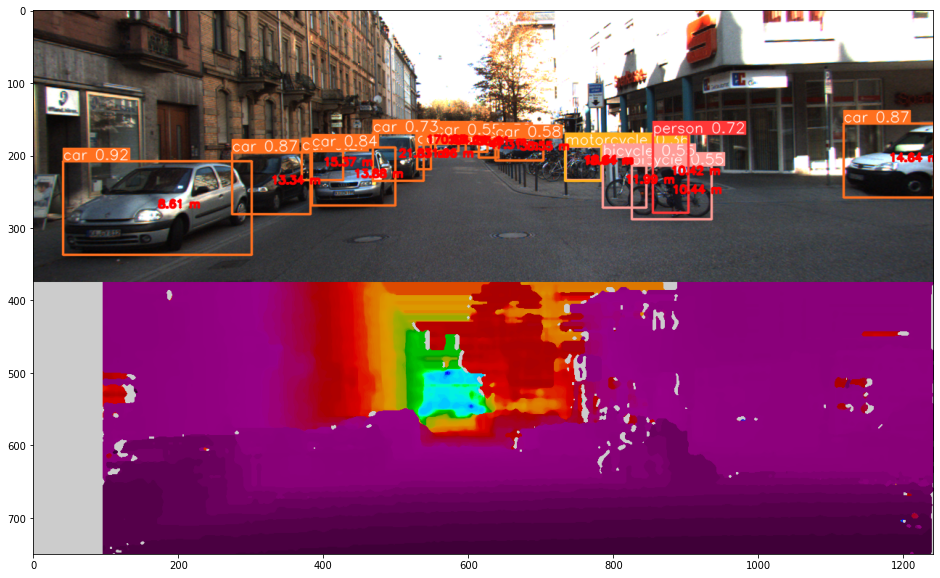

In [18]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

plt.imshow(stacked);

## **Convert image and Depth Map to point cloud array**

OpenCV uses the Q Matrix is used to get a 3D Point Cloud.
If you've done the calibration notebook, you saw this Q matrix as "disparity to depth".

**Structure of the Q Matrix:**<p>
![](https://answers.opencv.org/upfiles/15222662547364629.png)

It is obstained through stereo calibration, in particular, the function
```
Q = np.zeros(4,4)
cv2. stereoRectify (cameraMatrixLeft, CameraMatrixRight, distortion_coefficients_left, distortion_coefficients_right, image_size, R, T, R1, R2, P1, P2, Q)
```

Then, StereoRectify modifies the Q matrix.

**It then can be used the following:**<p>
![](https://answers.opencv.org/upfiles/1522266963686882.png)


In [19]:
# get Q matrix for reprojecting to 3D

# 0.54m is the distance between the two color cameras 
Tmat = np.array([0.54, 0., 0.])

Q = np.zeros((4,4))
cv2.stereoRectify(cameraMatrix1=K_left, 
                  cameraMatrix2=K_right, 
                  distCoeffs1=0,  
                  distCoeffs2=0,  
                  imageSize=left_image.shape[::-1][1:], 
                  R=R_left, 
                  T=Tmat, \
                  R1=None, 
                  R2=None, \
                  P1= None, 
                  P2= None, 
                  Q=Q);

print("Disparity To Depth")
print(Q)

Disparity To Depth
[[          1           0           0     -609.56]
 [          0           1           0     -172.85]
 [          0           0           0      721.54]
 [          0           0     -1.8519           0]]


## Now project the image to 3D
See https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02

In [ ]:
!pip install open3d

In [23]:
# reimport matplotlib after installing open3d
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### make a pipeline to display clusters on the image

In [24]:
def get_left_uv_from_xyz(xyz):
    '''Obtains the left image (u, v) coordinates from (x, y, z) coordinates '''

    # get homogeneous representation of 3D (x, y, z) points
    xyzw = np.hstack((xyz, np.ones((len(xyz), 1))))

    # convert 3D homogeneous coordinates to 2D homogeneous left image coordinates
    uvw = P_left @ R_left_rect @ xyzw.T

    # convert homogeneous coordinates to 2D (u, v) image coordinates
    uvw[:2, :] /= uvw[2, :]
    image_uv = np.round(uvw[:2, :]).astype(int)

    return image_uv

## **Make 3D obstacle detection pipeline**

1. reproject 2D points to 3D
2. load 3D points to open3d point cloud object
3. downsample and remove large plane with RANSAC 
4. Use KNN with KD Tree to cluster objects in 3D
5. Get min/max (x,y,z) points and get bounding box (or just use open3d)
6. Project 3D bounding box back to (u,v) space and draw it on image

In [25]:
def run_ransac(pcd, n_iters):
    ''' Run RANSAC on point cloud multiple times to remove large planes '''
    # set outlier_cloud here
    outlier_cloud = o3d.geometry.PointCloud()
    outlier_cloud.points = pcd.points

    for i in range(n_iters):
        _, inliers = pcd.segment_plane(distance_threshold=0.25,
                                       ransac_n=3,
                                       num_iterations=250)

        # get new segmented outlier cloud (update points in outlier cloud)
        outlier_cloud.points = outlier_cloud.select_by_index(inliers, invert=True).points

    return outlier_cloud

In [26]:
import open3d as o3d

def get_seeded_knn_clusters(pcd, pcd_tree, centroids, eps=2, max_points=500):
    ''' Obtains clusters using a KD Tree and K-Nearest Neighbors. Clusters are
        seeded by inputing the desired centroids
        steps:
            for each centroid
            get it's K-nearest neighbors 
            remove from search space all points within a set dist to the 
                original point 
            repeat
        Inputs:
            pcd - open3d PointCloud object
            pcd_tree - open3d PointCloud KDTreeFlann object
            centroids - (Nx3) array containing all desired centroids
            ep=2 (int) maximum distance from center to edge of cluster
            max_points=500 (int) maximum number of points in a cluster
        Outputs:
            object_clusters - (list) contains point cloud objects of detected
                object clusters
        '''
    # initialize the search space
    points_arr = np.asarray(pcd.points)
    search_space = np.arange(0, len(pcd.points))

    # collect objecct clusters in a list
    object_clusters = []

    for i, xyz_center in enumerate(object_centers_xyz):
        
        # get nearest neighbors to the object center no more than max_points
        [k, idx, dist] = pcd_tree.search_knn_vector_3d(xyz_center, max_points)
        
        # only keep points within a distance of ep
        idx_prune = np.array(idx)[np.array(dist) <= eps]
          
        # prune search space
        search_space = np.setdiff1d(search_space, idx_prune)
        
        # collect cluster in list and paint it
        cluster = pcd.select_by_index(idx_prune[1:])

        object_clusters.append(cluster)

    return object_clusters

In [37]:
def get_xyz_centers(bboxes, xyz):
    # get object centers in (u, v) left image space
    # z-values are the median of all boxed pixel depths
    object_centers_uvz = bboxes[:, 6:]

    # project object centers to (x, y, z) space
    object_centers_xyz = np.zeros_like(object_centers_uvz)

    for i, (u, v, z) in enumerate(object_centers_uvz):
        # get (x,y,z) inverse projection of (u,v) pixel
        object_centers_xyz[i, :] = xyz[int(u), int(v)]

    return object_centers_xyz 

In [66]:
def get_3d_clusters(xyz, object_centers_xyz):
    ''' full pipeline to get 3D cluster from reprojected 3D points '''
    # convert points array to point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(xyz.reshape((-1, 3))))

    # downsample point cloud
    downpcd = pcd.voxel_down_sample(voxel_size=0.15)

    # use multiple RANSAC iterations to remove large planes in point cloud
    outlier_cloud = run_ransac(downpcd, n_iters=1) # don't run for now

    # NOTE: RANSAC seems to crach kernel on Colab

    # get KD Tree from point cloud
    pcd_cloud_tree = o3d.geometry.KDTreeFlann(outlier_cloud)

    # get 3D object clusters via K-Means with KD-Tree
    object_clusters = get_seeded_knn_clusters(outlier_cloud, 
                                              pcd_cloud_tree, 
                                              object_centers_xyz, 
                                              eps=2, 
                                              max_points=400)
    
    return object_clusters

In [67]:
def get_left_uv_from_xyz(xyz):
    '''Obtains the left image (u, v) coordinates from (x, y, z) coordinates '''

    # get homogeneous representation of 3D (x, y, z) points
    xyzw = np.hstack((xyz, np.ones((len(xyz), 1))))

    # convert 3D homogeneous coordinates to 2D homogeneous left image coordinates
    uvw = P_left @ R_left_rect @ xyzw.T

    # convert homogeneous coordinates to 2D (u, v) image coordinates
    uvw[:2, :] /= uvw[2, :]
    image_uv = np.round(uvw[:2, :]).astype(int)

    return image_uv

In [68]:
tab20 = cm.get_cmap('tab20')
get_color = lambda z : [255*val for val in tab20 (z)[:3]]

def draw_clusters_on_image(clusters, image):
    ''' draws clusters on image '''
    for cluster in clusters:
        xyz = np.asarray(cluster.points)

        # account for 0 size clusters
        if len(xyz) == 0:
            continue
        
        image_uv = get_left_uv_from_xyz(xyz)

        # get cluster color
        color = get_color(int(np.random.uniform(0, 20)))

        # draw cluster points on image
        for (u, v) in image_uv.T:
            cv2.circle(image, (u, v), 1, color, -1)

## **Now Draw 3D bounding boxes on image**

In [69]:
def get_3d_bboxes(clusters):

    box_points_uv_list = []

    for cluster in clusters:

        # get 3d bounding box points in 3D space
        box_pts_xyz = np.asarray(cluster.points)

        # account for 0 point clusters
        if len(box_pts_xyz) == 0:
            continue

        # get min/max values in 3D space
        (x_min, y_min, z_min) = box_pts_xyz.min(axis=0)
        (x_max, y_max, z_max) = box_pts_xyz.max(axis=0)

        
        # now get points to define 3d bounding box
        # box_points = np.array([[x_max, y_max, z_max]]) * arr
        # just manually do this for now
        box_points = np.array([
            [x_max, y_max, z_max],
            [x_max, y_max, z_min],
            [x_max, y_min, z_max],
            [x_max, y_min, z_min],
            [x_min, y_max, z_max],
            [x_min, y_max, z_min],
            [x_min, y_min, z_max],
            [x_min, y_min, z_min]
        ])

        # project bounding box points to 2D (u,v) space
        box_pts_uv = get_left_uv_from_xyz(box_points)

        # append to list
        box_points_uv_list.append(box_pts_uv)

    return box_points_uv_list

In [70]:
def get_3d_bboxes_2(clusters, object_centers_xyz):
    ''' Forces objecrt centers to be the same as the 2d detected centers 
        STILL IN WORK
        '''

    box_points_uv_list = []

    for cluster, obj_center in zip(clusters, object_centers_xyz):

        # get 3d bounding box points in 3D space
        box_pts_xyz = np.asarray(cluster.points)

        # account for 0 point clusters
        if len(box_pts_xyz) == 0:
            continue

        # get min/max values in 3D space
        (x_min, y_min, z_min) = box_pts_xyz.min(axis=0)
        (x_max, y_max, z_max) = box_pts_xyz.max(axis=0)

        # force object centers to align with 2D detecrted object centers?
        # still in work
        x_min = x_min + obj_center[0]
        y_min = y_min + obj_center[1]
        z_min = z_min + obj_center[2]

        x_max = x_max + obj_center[0]
        y_max = y_max + obj_center[1]
        z_max = z_max + obj_center[2]
        
        # now get points to define 3d bounding box
        # box_points = np.array([[x_max, y_max, z_max]]) * arr
        # just manually do this for now
        box_points = np.array([
            [x_max, y_max, z_max],
            [x_max, y_max, z_min],
            [x_max, y_min, z_max],
            [x_max, y_min, z_min],
            [x_min, y_max, z_max],
            [x_min, y_max, z_min],
            [x_min, y_min, z_max],
            [x_min, y_min, z_min]
        ])

        # project bounding box points to 2D (u,v) space
        box_pts_uv = get_left_uv_from_xyz(box_points)

        # append to list
        box_points_uv_list.append(box_pts_uv)

    return box_points_uv_list

In [71]:
pastel = cm.get_cmap('Pastel2', lut=50)
get_pastel = lambda z : [255*val for val in pastel(z)[:3]]

def draw_3d_boxes(image, camera_box_points):
    for i, box_pts in enumerate(camera_box_points):
 
        [A, B, C, D, E, F, G, H] = box_pts.T
        color = get_pastel(i)

        # draw rear box (X-axis is forward for LiDAR)
        cv2.line(image, A, B, color, 2)
        cv2.line(image, B, D, color, 2)
        cv2.line(image, A, C, color, 2)
        cv2.line(image, D, C, color, 2)
        
        # draw front box
        cv2.line(image, G, E, color, 2)
        cv2.line(image, H, F, color, 2)
        cv2.line(image, G, H, color, 2)
        cv2.line(image, E, F, color, 2)

        # draw sides
        cv2.line(image, E, A, color, 2)
        cv2.line(image, G, C, color, 2)
        cv2.line(image, F, B, color, 2)
        cv2.line(image, H, D, color, 2)

    return image



In [72]:
tab20 = cm.get_cmap('tab20')
get_color = lambda z : [255*val for val in tab20 (z)[:3]]

def draw_clusters_on_image(clusters, image):
    ''' draws clusters on image '''
    for cluster in clusters:
        cluster_xyz = np.asarray(cluster.points)

        # account for 0 size clusters
        if len(cluster_xyz) == 0:
            continue
        
        # project to (u,v) coordinates
        cluster_uv = get_left_uv_from_xyz(cluster_xyz)

        # get cluster color
        color = get_color(int(np.random.uniform(0, 20)))

        # draw cluster points on image
        for (u, v) in cluster_uv.T:
            cv2.circle(image, (u, v), 1, color, -1)

    return image

## **Test the Object Cluster Pipeline**

In [73]:
idx = 55
left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)


## 1) detect objects and get depth measurements
left_image, left_disparity, depth_map, bboxes = get_depth_detections(
                                                              left_image, 
                                                              right_image, 
                                                              method='median',
                                                              draw_boxes=False, 
                                                              draw_depth=True)
    
## 2) project points to 3D
xyz = cv2.reprojectImageTo3D(left_disparity.copy(), Q)

## 3) get detected object centers in (x,y,z)
object_centers_xyz = get_xyz_centers(bboxes, xyz)

## 4) get 3D clusters 

# remove disparity portion of point when obtaining 3d clusters
object_clusters_xyz = get_3d_clusters(xyz[:, NUM_DISPARITIES:, :], object_centers_xyz)

## 5 Get 3D bounding boxes in (u, v) coordinates
box_points_uv = get_3d_bboxes(object_clusters_xyz)
# box_points_uv = get_3d_bboxes_2 (object_clusters_xyz, object_centers_xyz)

## 6 draw 3D boxes on the image
left_image = draw_3d_boxes(left_image, box_points_uv)

# draw Stereo point cloud on new blank image
new_image = np.zeros_like(left_image, dtype=np.uint8)
draw_clusters_on_image(object_clusters_xyz, new_image)

# stack frames
stacked = np.vstack((left_image, new_image))

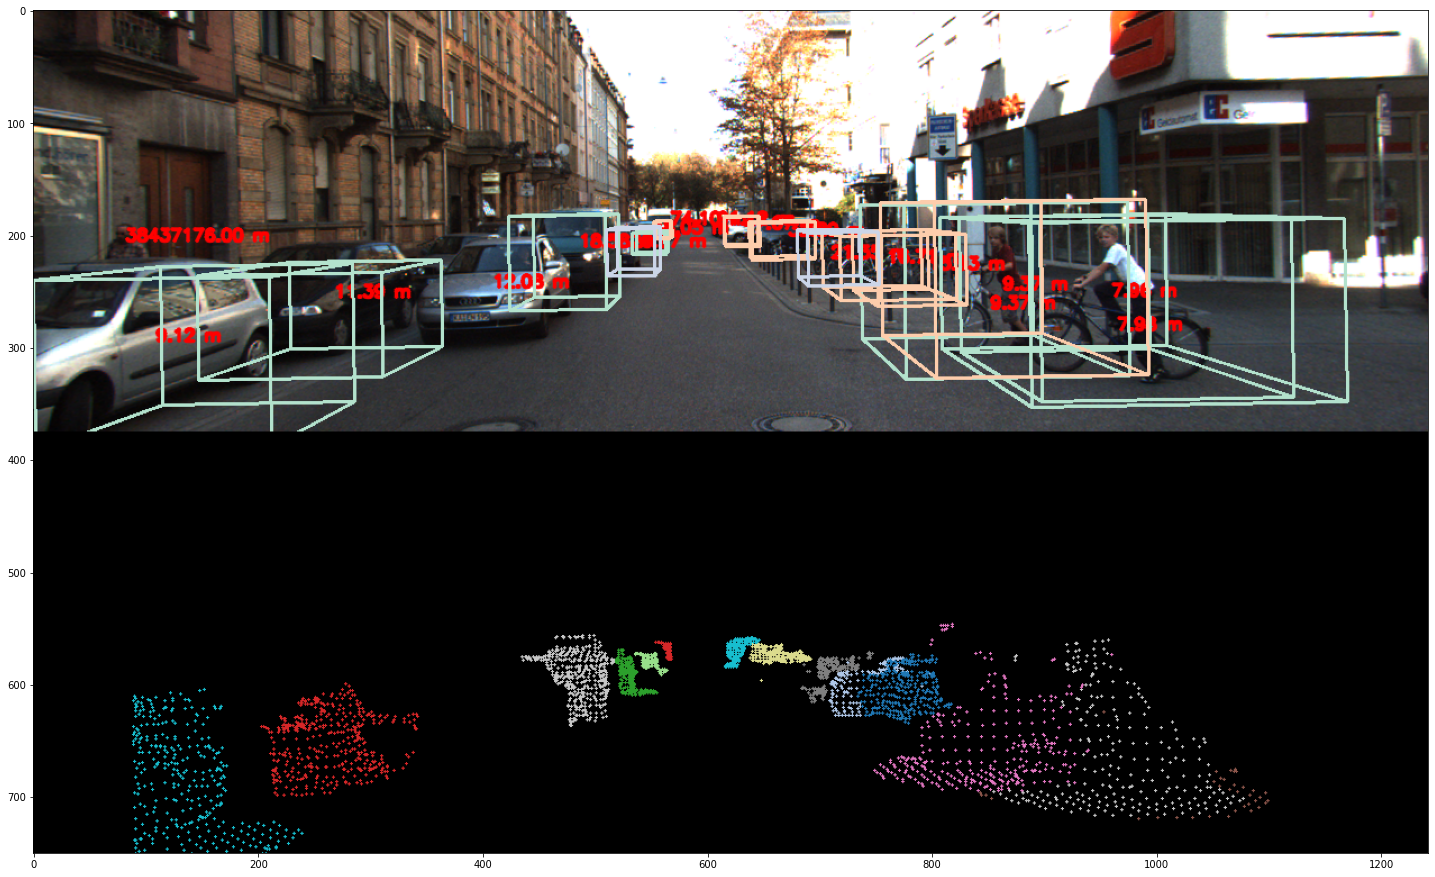

In [74]:
fig = plt.figure(figsize=(25, 25))
plt.imshow(stacked);

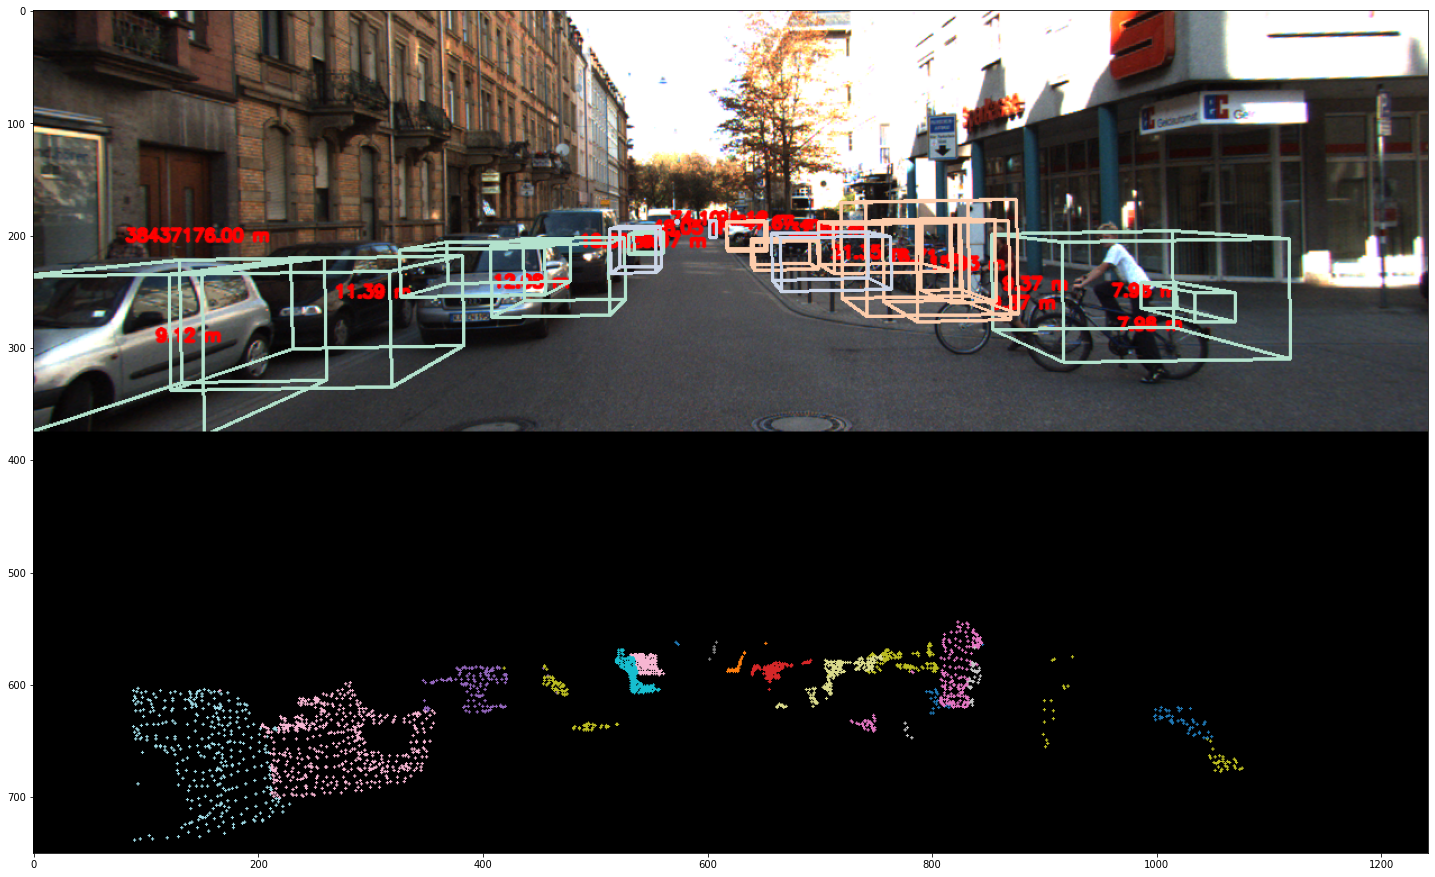

In [204]:
fig = plt.figure(figsize=(25, 25))
plt.imshow(stacked)

Notice that the clusters are typically very small and not always aligned with the real objects. There are a few things at work here. 
1. K-Means is not well suited for non-circular objects
2. The depth map isn't perfect and this impacts the clustering

The detected clusters will likely not center very well, we could shift the boxes to the center that was detected by out object detector.

In [159]:
result_video = []
points = cv2.reprojectImageTo3D(left_disparity.copy(), Q)



for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)


    ## 1) detect objects and get depth measurements
    left_image, left_disparity, depth_map, bboxes = get_depth_detections(
                                                                  left_image, 
                                                                  right_image, 
                                                                  method='median',
                                                                  draw_boxes=False, 
                                                                  draw_depth=True)

    ## 2) project disaprity to 3D (x,y,z) coordinates
    xyz = cv2.reprojectImageTo3D(left_disparity.copy(), Q)

    ## 3) get detected object centers in (x,y,z)
    object_centers_xyz = get_xyz_centers(bboxes, xyz)

    ## 4) get 3D clusters 

    # remove disparity portion of point when obtaining 3d clusters
    object_clusters_xyz = get_3d_clusters(xyz[:, NUM_DISPARITIES:, :], object_centers_xyz)

    
    ## 5 Get 3D bounding boxes in (u, v) coordinates
    box_points_uv = get_3d_bboxes(object_clusters_xyz)

    ## 6 draw 3D boxes on the image
    left_image = draw_3d_boxes(left_image, box_points_uv)

    # draw Stereo point cloud on new blank image
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    draw_clusters_on_image(object_clusters_xyz, new_image)
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)


# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_stereo_stack_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

## **Now let's run the depth check on another sample of KITTI data!**

In [205]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0051/2011_09_26_drive_0051_sync.zip

--2022-09-05 20:46:22--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0051/2011_09_26_drive_0051_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.29
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1702327445 (1.6G) [application/zip]
Saving to: ‘2011_09_26_drive_0051_sync.zip’

2011_09_26_drive_00 100%[===================>]   1.58G  31.7MB/s    in 55s     

2022-09-05 20:47:18 (29.7 MB/s) - ‘2011_09_26_drive_0051_sync.zip’ saved [1702327445/1702327445]



In [206]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-09-05 20:47:18--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.60
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip.1’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-09-05 20:47:18 (173 MB/s) - ‘2011_09_26_calib.zip.1’ saved [4068/4068]



In [210]:
!jar xf 2011_09_26_drive_0051_sync.zip

In [211]:
!jar xf 2011_09_26_calib.zip.1

### Get the Calibration data

In [75]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get distortion coefficients
d_left = [float(x) for x in calib[20].strip().split(' ')[1:]]
d_right = [float(x) for x in calib[28].strip().split(' ')[1:]]

# get unrectified intrinic matrices?
K_left_unrect = np.array([float(x) for x in calib[19].strip().split(' ')[1:]]).reshape((3, 3,))
K_right_unrect = np.array([float(x) for x in calib[27].strip().split(' ')[1:]]).reshape((3, 3,))

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)


In [76]:
Tmat = np.array([0.54, 0., 0.])

Q = np.zeros((4,4))
cv2.stereoRectify(cameraMatrix1=K_left, 
                  cameraMatrix2=K_right, 
                  distCoeffs1=0,  
                  distCoeffs2=0,  
                  imageSize=left_image.shape[::-1][1:], 
                  R=R_left, 
                  T=Tmat, \
                  R1=None, 
                  R2=None, \
                  P1= None, 
                  P2= None, 
                  Q=Q);

In [77]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0051_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))


print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")

Number of left images: 438
Number of right images: 438


## **Now let's make a video**

In [ ]:
result_video = []
points = cv2.reprojectImageTo3D(left_disparity.copy(), Q)


for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)


    ## 1) detect objects and get depth measurements
    left_image, left_disparity, depth_map, bboxes = get_depth_detections(
                                                                  left_image, 
                                                                  right_image, 
                                                                  method='median',
                                                                  draw_boxes=False, 
                                                                  draw_depth=True)

    ## 2) project disaprity to 3D (x,y,z) coordinates
    xyz = cv2.reprojectImageTo3D(left_disparity.copy(), Q)

    ## 3) get detected object centers in (x,y,z)
    object_centers_xyz = get_xyz_centers(bboxes, xyz)

    ## 4) get 3D clusters 

    # remove disparity portion of point when obtaining 3d clusters
    object_clusters_xyz = get_3d_clusters(xyz[:, NUM_DISPARITIES:, :], object_centers_xyz)

    
    ## 5 Get 3D bounding boxes in (u, v) coordinates
    box_points_uv = get_3d_bboxes(object_clusters_xyz)

    ## 6 draw 3D boxes on the image
    left_image = draw_3d_boxes(left_image, box_points_uv)

    # draw Stereo point cloud on new blank image
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    draw_clusters_on_image(object_clusters_xyz, new_image)
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)


# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_stereo_stack_2011_09_26_0051.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

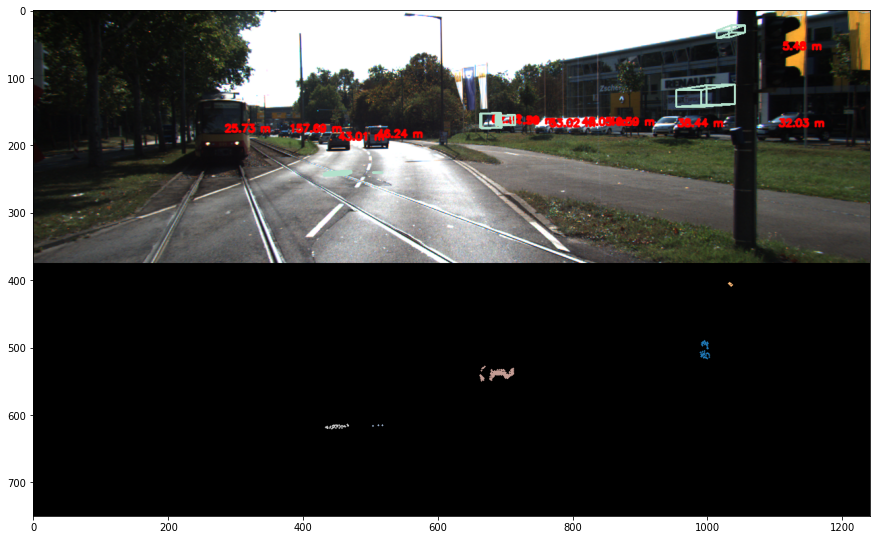

In [217]:
fig = plt.figure(figsize=(15,15))
plt.imshow(stacked);